<a href="https://colab.research.google.com/github/mangeshb1/nlp_experiments/blob/main/FineTune_BERT_NLP_working_GIT_Coursera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

### Contents


- **[1]()**: Download and Import the Quora Insincere Questions Dataset
- **[2]()**: Create tf.data.Datasets for Training and Evaluation
- **[3]()**: Download a Pre-trained BERT Model from TensorFlow Hub
- **[4]()**: Tokenize and Preprocess Text for BERT
- **[5]()**: Wrap a Python Function into a TensorFlow op for Eager Execution
- **[6]()**: Create a TensorFlow Input Pipeline with `tf.data`
- **[7]()**: Add a Classification Head to the BERT `hub.KerasLayer`
- **[8]()**: Fine-Tune BERT for Text Classification
- **[9]()**: Evaluate the BERT Text Classification Model

In [ ]:
!nvidia-smi

Thu Nov 26 11:54:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf

In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1388 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 9.73 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt

## 1: Download and Import the Quora Insincere Questions Dataset

In [ ]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [ ]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', 
                 compression='zip', low_memory=False)


,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


In [ ]:
df.tail(20)

In [ ]:
df.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

## 2: Create tf.data.Datasets for Training and Evaluation

In [ ]:
train ,remaining = train_test_split(df, train_size=0.0060, random_state=42, stratify=df.target.values)
validation, remaining = train_test_split(remaining, random_state=42, train_size=0.00060, stratify=remaining.target.values)
test, remaining = train_test_split(remaining, random_state=42, train_size=0.00060, stratify=remaining.target.values)

print("Train Shape\tValid Shape\tTest Shape")
train.shape, validation.shape, test.shape



Train Shape	Valid Shape	Test Shape


((7836, 3), (778, 3), (778, 3))

In [ ]:
 with tf.device('/cpu:0'):
   train_data = tf.data.Dataset.from_tensor_slices((train['question_text'].values, train['target'].values))
   valid_data = tf.data.Dataset.from_tensor_slices((validation['question_text'].values, validation['target'].values))
   test_data = tf.data.Dataset.from_tensor_slices((test['question_text'].values, test['target'].values))

   for text, label in train_data.take(1):
     print(test)
     print(label)

                         qid  ... target
278090  366dba9c1177ab4e0822  ...      0
331559  40fe20bb8200de27a3a9  ...      0
403442  4f0d88ed46574758c92b  ...      0
41033   0806a3d41864fc2d60ea  ...      0
522597  664d264b58b40c0559f4  ...      0
...                      ...  ...    ...
643727  7e13e6bcff261cf6a4ba  ...      0
344618  4386b8eb4c99a47a5f83  ...      0
848227  a632a2addc51d6c5c2ad  ...      0
555132  6cc4d385fcc672ad4c8a  ...      0
401527  4eabbe91163e9aa59ee0  ...      0

[778 rows x 3 columns]
tf.Tensor(0, shape=(), dtype=int64)


## 3: Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""
labels_list = [0, 1]
max_seq_len = 150
batch = 64

#: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=False)
vocab = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab, do_lower_case)

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize("hi, how, are you")

['hi', '##,', 'how', '##,', 'are', 'you']

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize("hi, How, are you")

['hi', '##,', '[UNK]', 'are', 'you']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("hi, how, are you"))

[7632, 29623, 2129, 29623, 2024, 2017]

## 4: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray"> BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=labels_list, max_seq_length=max_seq_len, tokenizer=tokenizer):
   
   example = classifier_data_lib.InputExample(guid=None,
                                              text_a=text.numpy(),
                                              text_b=None,
                                              label=label.numpy()
                                              )
   feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
   
   return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

We want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode we can only use TensorFlow Ops and functions.

So we can't `.map` this function directly: We need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## 5: Wrap a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32]
                                                                )
  input_ids.set_shape([max_seq_len])
  input_mask.set_shape([max_seq_len])
  segment_ids.set_shape([max_seq_len])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
       'input_mask':input_mask,
       'input_type_ids':segment_ids
  }
  return (x, label_id) 

## 6: Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE
                               )
  .shuffle(1000)
  .batch(batch, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE)
  )

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE
                               )
  .batch(batch, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE)
  )
  
  # test
  test_data = (test_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE
                               )
  .batch(batch, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE)
  )
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None)},
 TensorSpec(shape=(64,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None)},
 TensorSpec(shape=(64,), dtype=tf.int32, name=None))

## 7: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray"> BERT Layer</p>
</div>

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                   name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                    name="segment_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

  drop = tf.keras.layers.Dropout(0.3)(pooled_output)
  dense_1 = tf.keras.layers.Dense(512, activation='relu')(drop)
  dense_2 = tf.keras.layers.Dense(1024, activation='relu')(dense_1)
  dense_3 = tf.keras.layers.Dense(1024, activation='relu')(dense_2)
  drop = tf.keras.layers.Dropout(0.4)(dense_3)
  
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)

  model = tf.keras.Model(
      {
        'input_word_ids': input_word_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
      },
      output
  )
  return model

## 8: Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 150)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 150)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 150)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 150, 768)]                'input_mask[0][0]',         

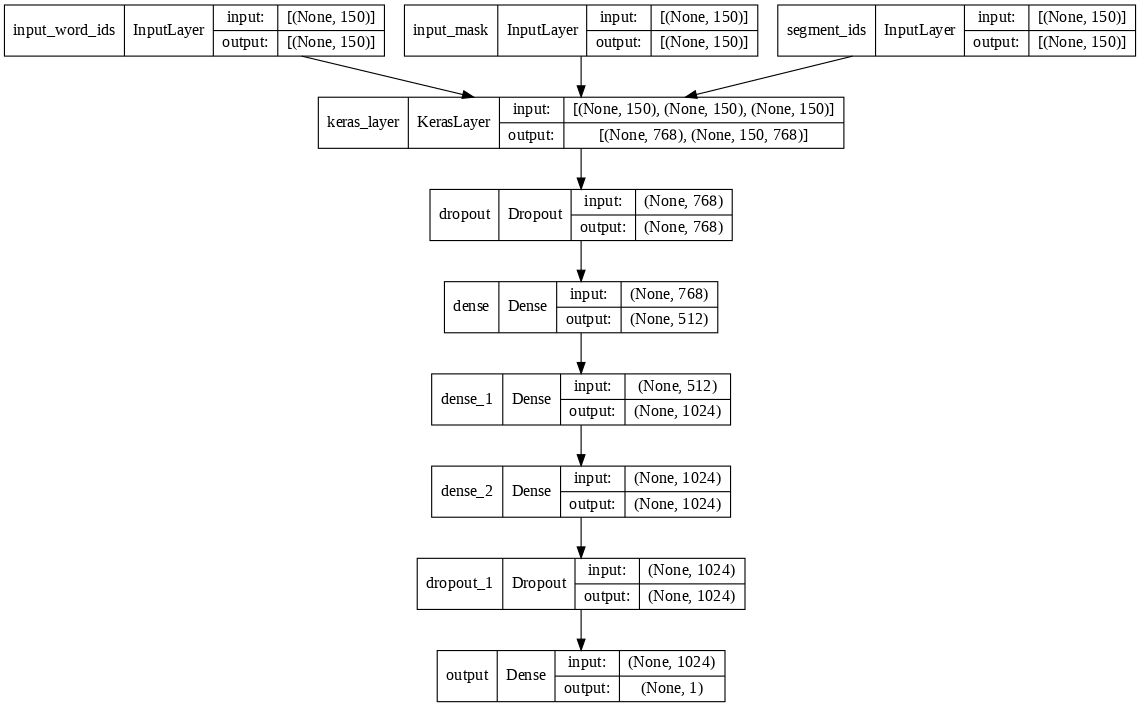

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=80)

In [ ]:
# Train model
h = model.fit(train_data, validation_data=valid_data,
              epochs=2
)

Epoch 1/2
122/122 [==============================] - 194s 1s/step - loss: 0.2381 - binary_accuracy: 0.9363 - val_loss: 0.2127 - val_binary_accuracy: 0.9375
Epoch 2/2
122/122 [==============================] - 180s 1s/step - loss: 0.2141 - binary_accuracy: 0.9376 - val_loss: 0.1950 - val_binary_accuracy: 0.9362


## 9: Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

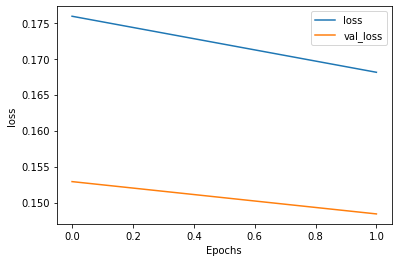

In [ ]:
plot_graphs(h, 'loss')

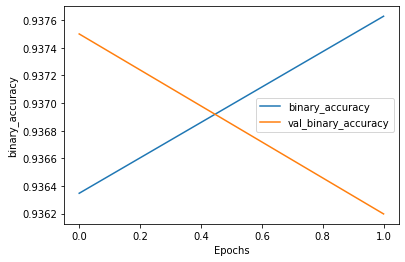

In [ ]:
plot_graphs(h, 'binary_accuracy')

In [ ]:
model.evaluate(test_data)

12/12 [==============================] - 16s 1s/step - loss: 0.1777 - binary_accuracy: 0.9388


[0.1777157038450241, 0.9388020634651184]

In [ ]:
sample_example = ['may i have your number??']
ques = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
ques = (ques.map(to_feature_map)).batch(1)
pred = model.predict(ques)[0][0]
print(pred)
t = 0.5
['Insincere' if pred>=t else 'Sincere']

0.019330569


['Sincere']

In [ ]:
sample_example = ['Are you ashamed of being an Indian?']
ques = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
ques = (ques.map(to_feature_map)).batch(1)
pred = model.predict(ques)[0][0]

print(pred)
t = 0.5
['Insincere' if pred>=t else 'Sincere']

0.04090614


['Sincere']

In [ ]:
print(type(model))

<class 'keras.engine.functional.Functional'>


In [ ]:
model.save('dummy_bert_model_finetunned')

INFO:tensorflow:Assets written to: dummy_bert_model_finetunned/assets


INFO:tensorflow:Assets written to: dummy_bert_model_finetunned/assets


In [ ]:
!pwd

/content


In [ ]:
save_directory = '/content/dummy_bert_model_finetunned'

In [ ]:
# !pip install transformers

In [ ]:
# !pip install keras2onnx

In [ ]:
# !pip install onnxruntime

In [ ]:
# let's install the onnx packages from the source
!pip install --quiet -U onnxruntime
!pip install --quiet -U git+https://github.com/microsoft/onnxconverter-common
!pip install --quiet -U git+https://github.com/onnx/keras-onnx

In [ ]:
import keras2onnx
print("keras2onnx version is "+keras2onnx.__version__)
# convert to onnx model
onnx_model = keras2onnx.convert_keras(model, 'bert-dummy', debug_mode=1)
output_model_path = "./bert-dummy.onnx"
# and save the model in ONNX format
keras2onnx.save_model(onnx_model, output_model_path)

AttributeError: ignored

In [ ]:
# runtime prediction
content = onnx_model.SerializeToString()
sess = onnxruntime.InferenceSession(content)
x = x if isinstance(x, list) else [x]
feed = dict([(input.name, x[n]) for n, input in enumerate(sess.get_inputs())])
pred_onnx = sess.run(None, feed)